In [367]:
import numpy as np 
from numpy import random as rnd
from matplotlib import pyplot as plt 
import seaborn as sns
from scipy import stats as stats
from scipy.special import factorial
import seaborn as sns

In [5]:
import sys 
sys.path

['/Users/joshstern/Documents/am231/FinalProject',
 '/Library/Frameworks/Python.framework/Versions/3.8/lib/python38.zip',
 '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8',
 '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload',
 '',
 '/Users/joshstern/Library/Python/3.8/lib/python/site-packages',
 '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages',
 '/Users/joshstern/atomProjects/Chillin/nn-brain/neurogym/examples/neurogym',
 '/Users/joshstern/atomProjects/Chillin/ssmdm',
 '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions',
 '/Users/joshstern/.ipython']

## Generic Kalman Filter

First, experiment with Generic Kalman filter for simple linear state-space model. 

We use the following generative model: 

$$\theta_{t} = \theta_{t-1} + \epsilon_{t}$$

$$y_{t} = \theta_t + \delta_{t}$$

Where $\epsilon_{t}\sim N(0,\sigma_{process}^2)$ and $\delta_{t}\sim N(0,\sigma_{obs}^2)$

Which yields the following update equations: 

$$\theta_{t|t} = \theta_{t|t-1} + \frac{\sigma_{t|t-1}^2}{\sigma_{obs}^2 + \sigma_{t|t-1}^2}(y_t - \theta_{t|t-1})$$

$$\sigma_{t|t}^2 = \frac{\sigma_{obs}^2 \sigma_{t|t-1}^2}{\sigma_{obs}^2 + \sigma_{t|t-1}^2}$$

In [2]:
def kalman_filter_basic(y,var_obs): 
    seq_len = len(y) 
    theta_est = np.zeros(seq_len) 
    var_est = np.zeros(seq_len)
    var_est[0] = var_obs
    for t in range(1,seq_len): 
        theta_est[t] = theta_est[t-1] + var_est[t-1] / (var_obs + var_est[t-1]) * (y[t] - theta_est[t-1])
        var_est[t] = var_obs * var_est[t-1] / (var_obs + var_est[t-1])
        
    return theta_est,var_est

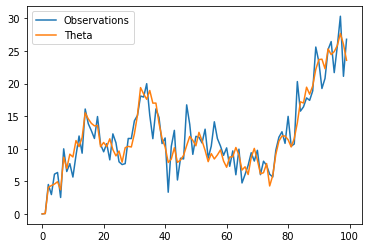

In [3]:
# generate data
seq_len = 100
var_process = 3
var_obs = 5
theta = np.zeros(seq_len)
y = np.zeros(seq_len)
for t in range(1,seq_len): 
    theta[t] = theta[t-1] + rnd.normal(0,np.sqrt(var_process))
    y[t] = theta[t] + rnd.normal(0,np.sqrt(var_obs))

plt.figure() 
plt.plot(y,label = "Observations")
plt.plot(theta,label = "Theta") 
plt.legend()
plt.show()

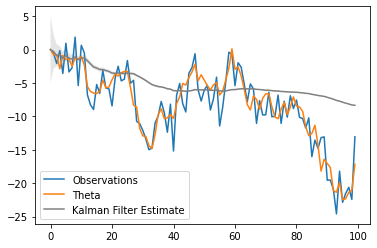

In [79]:
# plot kalman filter results
theta_est,var_est = kalman_filter_basic(y,var_obs) 

plt.figure() 
plt.plot(y,label = "Observations")
plt.plot(theta,label = "Theta") 
plt.plot(theta_est,color = [.5,.5,.5],label = "Kalman Filter Estimate")
plt.fill_between(np.arange(seq_len), theta_est-var_est, theta_est+var_est,fc = [.8,.8,.8],alpha = .5)
plt.legend()
plt.show()

In [73]:
def kalman_filter_decay(y,var_obs,decay,init): 
    seq_len = len(y) 
    theta_est = np.zeros(seq_len) 
    theta_est[0] = init
    var_est = np.zeros(seq_len)
    var_est[0] = var_obs
    for t in range(1,seq_len): 
        theta_est[t] = decay * theta_est[t-1] + var_est[t-1] / (var_obs + var_est[t-1]) * (y[t] - theta_est[t-1])
        var_est[t] = var_obs * var_est[t-1] / (var_obs + var_est[t-1])
        
    return theta_est,var_est

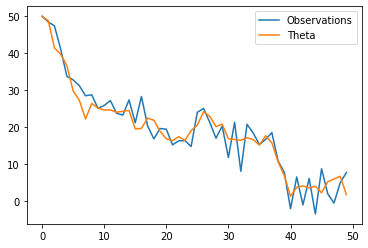

In [74]:
# generate data with decay
seq_len = 50
init = 50
var_process = 10
var_obs = 10
theta = np.zeros(seq_len)
y = np.zeros(seq_len) 
theta[0] = y[0] = init
decay = 0.95
for t in range(1,seq_len): 
    theta[t] = max(0,decay * theta[t-1] + rnd.normal(0,np.sqrt(var_process)))
    y[t] = theta[t] + rnd.normal(0,np.sqrt(var_obs))

plt.figure() 
plt.plot(y,label = "Observations")
plt.plot(theta,label = "Theta") 
plt.legend()
plt.show()

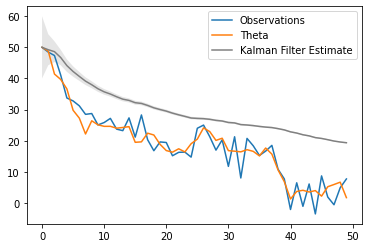

In [75]:
# plot kalman filter results
theta_est,var_est = kalman_filter_decay(y,var_obs,decay,init) 

plt.figure() 
plt.plot(y,label = "Observations")
plt.plot(theta,label = "Theta") 
plt.plot(theta_est,color = [.5,.5,.5],label = "Kalman Filter Estimate")
plt.fill_between(np.arange(seq_len), theta_est-var_est, theta_est+var_est,fc = [.8,.8,.8],alpha = .5)
plt.legend()
plt.show()

## Point Process State Space Model 

We take the setting of a point process. Let the reward events $0 < u_1 < u_2 < ... < u_L$ be a realization from a point process with conditional intensity function $\lambda(u | H_u)$ where $u$ is a continuous-valued non-negative variable that denotes continuous time. N.B. we will use $t$ to denote a discrete time index. Let $N(u)$ be the associated counting process.

By definition of the CIF: 

$$P(N(u + \Delta) - N(u) = 1 | H_u ) \approx \lambda(u|H_u)\Delta + o(\Delta)  $$

s.t. with small enough discretization $\Delta$, $y_t \in \{0,1\}$

$$p(y_t | H_t) = (\lambda(t | H_t)\Delta)^y e^{-\lambda (t|H_t)\Delta}   $$


Then let $\lambda(t | \theta_t,H_t) = e^{\theta_t}$
We adopt a SRW on the dynamics of $\theta_t$ s.t. $\theta_t = \theta_{t-1} + \epsilon_{t}$ where $\epsilon_t \sim N(0,\sigma_\epsilon^2)$. This yields $\sigma_{t|t-1}^2 = \sigma_{t-1|t-1}^2 + \sigma_{\epsilon}^2 $

Solving the filtering equation, we arrive at: 

$$\theta_{t|t} = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - e^{\theta_{t|t-1}}\Delta ) = \theta_{t | t-1} + \sigma_{t|t}^2 (y_t - \lambda(t | \theta_{t},H_t)\Delta ) $$

$$\sigma_{t|t}^2 = \left(\lambda(t | \theta_{t-1},H_t)\Delta + \frac{1}{\sigma_{t|t-1}^2}   \right)^{-1} $$

We will initialize $\theta_{0|0}$ and $\sigma^2_{0|0}$ according to some prior distribution. (Gamma?)

In [470]:
def ppssm(y,theta_0,sigma2_0,sigma2_eps,dt): 
    """ 
        Calculate estimated rate lambda and its variance 
        From a binary sequence y according to PPSSM filtering equations
    """
    seq_len = len(y)
    theta = np.concatenate((np.array([theta_0]),np.array(np.zeros(seq_len-1))))
    sigma2 = np.concatenate((np.array([sigma2_0]),np.array(np.zeros(seq_len-1))))
    for t in range(1,seq_len): 
        sigma2_given_tminus1 = sigma2[t-1] + sigma2_eps
        theta[t] = theta[t-1] + sigma2_given_tminus1 * (y[t] - dt*np.exp(theta[t-1]))
#         print((1 / (dt*np.exp(theta[t-1]) + 1/sigma2_given_tminus1)))
        sigma2[t] = np.min([1e-1,(1 / (dt*np.exp(theta[t-1]) + 1/sigma2_given_tminus1))])
    return theta,sigma2

def stream_from_events(event_times,end_t,dt): 
    """ 
        Convert event times into a binary stream of continuous data
    """ 
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    rew_stream[rew_ix] = 1
    return rew_stream

def stream_from_sized_events(event_times,event_sizes,end_t,dt): 
    """
        Approximate rewards of varying sizes by using multiple positive events in a row
    """
    rew_ix = np.round(event_times / dt).astype(int)
    rew_stream = np.zeros(int(np.round(end_t / dt)))
    for ix,dur in zip(rew_ix,event_sizes):
        rew_stream[ix:ix+dur] = 1
    return rew_stream

Now simulate some sequences of rewards and run them through the PPSSM model. 

- What happens for various $\sigma_{\epsilon}^2$? Tune this by hand, or choose to maximize the prediction likelihood (something somewhat similar to RPE)
- What happens for various initializations of $\theta_0$ and $\sigma^2_0$?

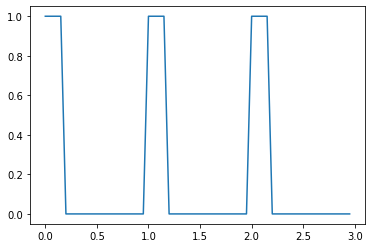

In [471]:
# Reward stream creation functions
theta_0 = 3 
sigma_0 = 2 
sigma_eps = 2
dt = 0.05 # 50 ms
end_t = 3
# y = stream_from_events(rew_times,end_t,dt)
rew_times = np.array([0,1,2])
rew_sizes = np.full(len(rew_times),4)
y = stream_from_sized_events(rew_times,rew_sizes,end_t,dt)
t = np.arange(0,end_t,dt)

plt.plot(t,y)
plt.show()


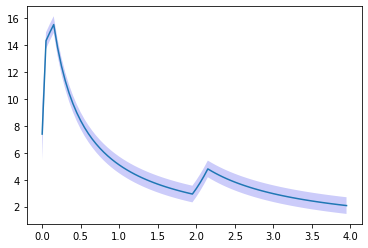

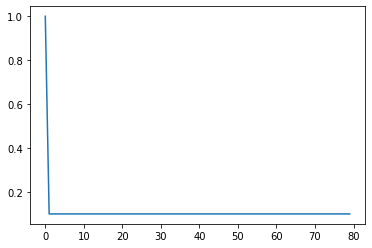

In [472]:
# Plot PPSSM predictions, first for one set of parameters
end_t = 4
dt = 0.05
t = np.arange(0,end_t,dt)
rew_times = np.array([0,2])
rew_sizes = np.full(len(rew_times),4)
y = stream_from_sized_events(rew_times,rew_sizes,end_t,dt)

theta_0 = 2
sigma2_0 = 1
sigma2_eps = .05
theta,sigma2 = ppssm(y,theta_0,sigma2_0,sigma2_eps,dt)
lam = np.exp(theta)
plt.plot(t,lam)
plt.fill_between(t, lam - 1.96 * np.sqrt(sigma2), lam + 1.96 * np.sqrt(sigma2),fc = [0,0,.9],alpha = .2)
plt.show()
plt.plot(sigma2) 
plt.show()

In [473]:
# Define a few trial types
r00 = stream_from_sized_events(np.array([0]),np.array([4]),end_t,dt)
rr0 = stream_from_sized_events(np.array([0,1]),np.array([4,4]),end_t,dt)
r0r = stream_from_sized_events(np.array([0,2]),np.array([4,4]),end_t,dt)
rrr = stream_from_sized_events(np.array([0,1,2]),np.array([4,4,4]),end_t,dt)

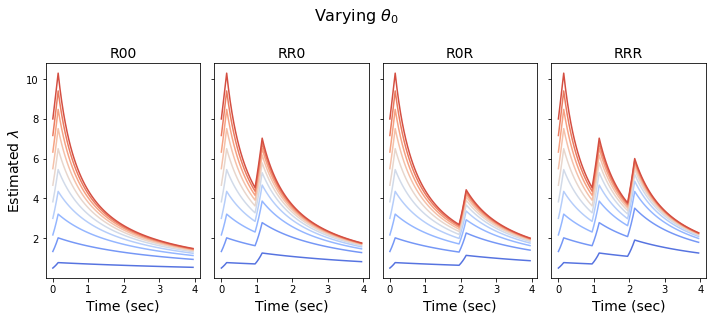

In [488]:
def cmap_lineplot(t,X,cmap,ax = None):  
    if ax: 
        for i in range(X.shape[0]): 
            ax.plot(t,X[i,:],c = cmap[i])
    else: 
        for i in range(X.shape[0]): 
            plt.plot(t,X[i,:],c = cmap[i])

# First vary theta_0, prior on reward rate
n_param_tiles = 10
theta_0_range = np.log(np.linspace(.5,8,n_param_tiles))
r00_lam = np.zeros((n_param_tiles,len(r00)))
rr0_lam = np.zeros((n_param_tiles,len(r00)))
r0r_lam = np.zeros((n_param_tiles,len(r00)))
rrr_lam = np.zeros((n_param_tiles,len(r00)))
sigma2_eps = .05
sigma2_0 = 0.1
for i,this_theta0 in enumerate(theta_0_range): 
    this_theta_r00,_ = ppssm(r00,this_theta0,sigma2_0,sigma2_eps,dt)
    this_theta_rr0,_ = ppssm(rr0,this_theta0,sigma2_0,sigma2_eps,dt)
    this_theta_r0r,_ = ppssm(r0r,this_theta0,sigma2_0,sigma2_eps,dt)
    this_theta_rrr,_ = ppssm(rrr,this_theta0,sigma2_0,sigma2_eps,dt)
    r00_lam[i,:] = np.exp(this_theta_r00)
    rr0_lam[i,:] = np.exp(this_theta_rr0)
    r0r_lam[i,:] = np.exp(this_theta_r0r)
    rrr_lam[i,:] = np.exp(this_theta_rrr)

fig1,ax = plt.subplots(1,4,figsize = (10,4),sharey = True)
cmap_lineplot(t,r00_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[0])
ax[0].set_title("R00",fontsize = 14,)
ax[0].set_xlabel("Time (sec)",fontsize = 14,)
ax[0].set_ylabel(r"Estimated $\lambda$",fontsize = 14,)
cmap_lineplot(t,rr0_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[1])
ax[1].set_title("RR0",fontsize = 14,)
ax[1].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,r0r_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[2])
ax[2].set_title("R0R",fontsize = 14,)
ax[2].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,rrr_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[3])
ax[3].set_title("RRR",fontsize = 14,)
ax[3].set_xlabel("Time (sec)",fontsize = 14,)
fig1.suptitle(r"Varying $\theta_{0}$",fontsize = 16,y=1.1)
fig1.tight_layout()
plt.show()

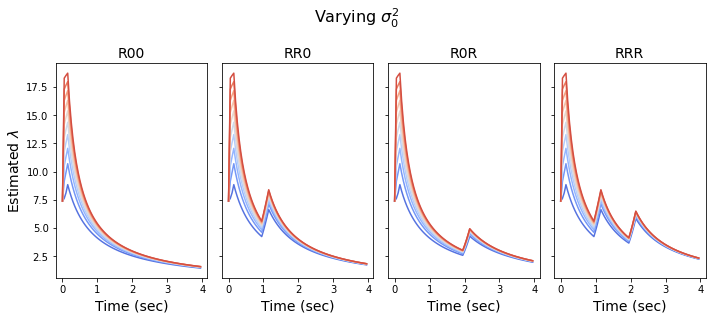

In [489]:
# Now vary sigma2_0, prior on reward rate variance
n_param_tiles = 10
sigma2_0_range = np.log(np.linspace(1,4,n_param_tiles))
r00_lam = np.zeros((n_param_tiles,len(r00)))
rr0_lam = np.zeros((n_param_tiles,len(r00)))
r0r_lam = np.zeros((n_param_tiles,len(r00)))
rrr_lam = np.zeros((n_param_tiles,len(r00)))
sigma2_eps = .05
theta0 = 2
for i,this_sigma2_0 in enumerate(sigma2_0_range): 
    this_theta_r00,_ = ppssm(r00,theta0,this_sigma2_0,sigma2_eps,dt)
    this_theta_rr0,_ = ppssm(rr0,theta0,this_sigma2_0,sigma2_eps,dt)
    this_theta_r0r,_ = ppssm(r0r,theta0,this_sigma2_0,sigma2_eps,dt)
    this_theta_rrr,_ = ppssm(rrr,theta0,this_sigma2_0,sigma2_eps,dt)
    r00_lam[i,:] = np.exp(this_theta_r00)
    rr0_lam[i,:] = np.exp(this_theta_rr0)
    r0r_lam[i,:] = np.exp(this_theta_r0r)
    rrr_lam[i,:] = np.exp(this_theta_rrr)

fig2,ax = plt.subplots(1,4,figsize = (10,4),sharey = True)
cmap_lineplot(t,r00_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[0])
ax[0].set_title("R00",fontsize = 14,)
ax[0].set_xlabel("Time (sec)",fontsize = 14,)
ax[0].set_ylabel(r"Estimated $\lambda$",fontsize = 14,)
cmap_lineplot(t,rr0_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[1])
ax[1].set_title("RR0",fontsize = 14,)
ax[1].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,r0r_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[2])
ax[2].set_title("R0R",fontsize = 14,)
ax[2].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,rrr_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[3])
ax[3].set_title("RRR",fontsize = 14,)
ax[3].set_xlabel("Time (sec)",fontsize = 14,)
fig2.suptitle(r"Varying $\sigma^2_{0}$",fontsize = 16,y=1.1)
fig2.tight_layout()
plt.show()

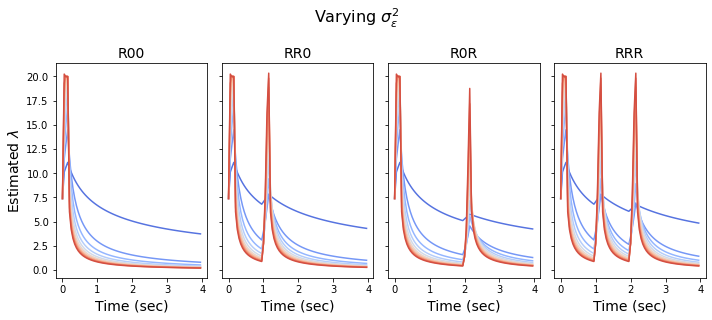

In [490]:
# Now vary sigma2_eps, estimate of process noise
n_param_tiles = 10
sigma2_eps_range = np.log(np.linspace(1,3,n_param_tiles))
r00_lam = np.zeros((n_param_tiles,len(r00)))
rr0_lam = np.zeros((n_param_tiles,len(r00)))
r0r_lam = np.zeros((n_param_tiles,len(r00)))
rrr_lam = np.zeros((n_param_tiles,len(r00)))
theta0 = 2
sigma2_0 = .5
for i,this_sigma2_eps in enumerate(sigma2_eps_range): 
    this_theta_r00,_ = ppssm(r00,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_rr0,_ = ppssm(rr0,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_r0r,_ = ppssm(r0r,theta0,sigma2_0,this_sigma2_eps,dt)
    this_theta_rrr,_ = ppssm(rrr,theta0,sigma2_0,this_sigma2_eps,dt)
    r00_lam[i,:] = np.exp(this_theta_r00)
    rr0_lam[i,:] = np.exp(this_theta_rr0)
    r0r_lam[i,:] = np.exp(this_theta_r0r)
    rrr_lam[i,:] = np.exp(this_theta_rrr)

fig3,ax = plt.subplots(1,4,figsize = (10,4),sharey = True)
cmap_lineplot(t,r00_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[0])
ax[0].set_title("R00",fontsize = 14,)
ax[0].set_xlabel("Time (sec)",fontsize = 14,)
ax[0].set_ylabel(r"Estimated $\lambda$",fontsize = 14,)
cmap_lineplot(t,rr0_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[1])
ax[1].set_title("RR0",fontsize = 14,)
ax[1].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,r0r_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[2])
ax[2].set_title("R0R",fontsize = 14,)
ax[2].set_xlabel("Time (sec)",fontsize = 14,)
cmap_lineplot(t,rrr_lam,sns.color_palette("coolwarm",n_param_tiles),ax = ax[3])
ax[3].set_title("RRR",fontsize = 14,)
ax[3].set_xlabel("Time (sec)",fontsize = 14,)
fig3.suptitle(r"Varying $\sigma^2_{\epsilon}$",fontsize = 16,y=1.1)
fig3.tight_layout()
plt.show()

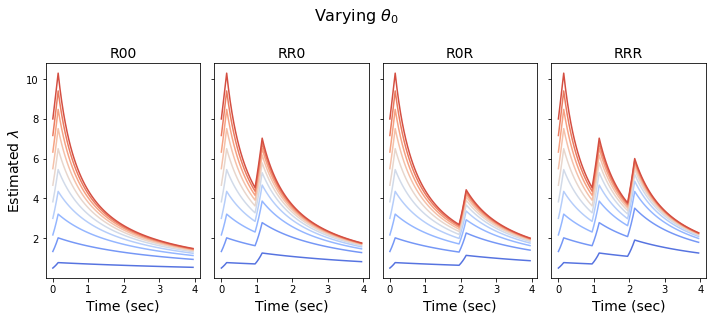

In [500]:
fig1

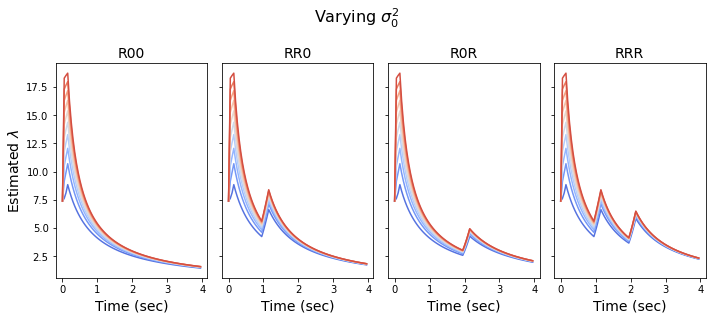

In [501]:
fig2

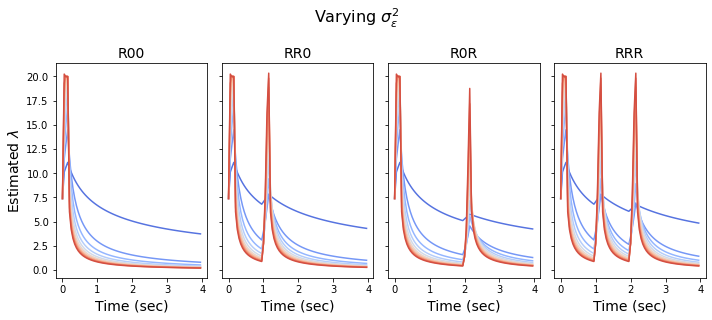

In [502]:
fig3

## Kilpatrick, Davidson, and El Hady model

If reward delivery depletes the patch: 

$$\lambda(t) = \lambda_0 - \rho K(t) $$

If the patch just depletes linearly with time: 

$$\lambda(t) = \lambda_0 - \rho t $$ 

If the patch depletes exponentially with time (our case): 

$$\lambda(t) = \lambda_0 - e^{\rho t}$$

Inter-arrival time $T_{k}$ between the $k$ and $k+1$th arrivals $\sim Expo(\lambda_0 - \rho K)$

Initialize belief with prior $p_{0}(\lambda)$ Yields: 

$$p(\lambda | x(t)) = \frac{p(x(t)|\lambda)p_{0}(\lambda + K(t)\rho)}{p(x(t))} $$

$$p(\lambda | x(t)) \propto p(x(t)|\lambda)p_0 (\lambda + K\rho)  $$

This step I'm unsure of the fraction of factorials: 

$$p(\lambda | x(t)) \propto \frac{(\lambda/\rho + K)!}{(\lambda/\rho)!}e^{-\lambda t}p_{0}(\lambda + K\rho) $$

But overall nice; we have something that is a multiplication of a proximal reward rate estimate and a prior on reward rate overall

Let's let $p_0$ be gaussian for concreteness.

In [233]:
def x_likelihood(lam_xvals,rho,k,t): 
    return (np.array([factorial(lam / rho + k) for lam in lam_xvals]) / np.array([factorial(lam / rho) for lam in lam_xvals])) * np.exp(-lam_xvals * i_t)


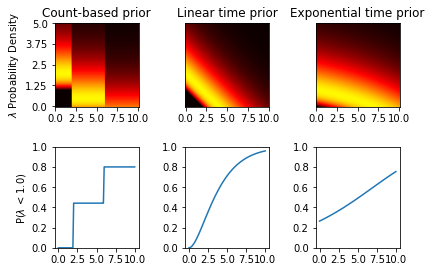

In [341]:
# Make a prior heatmap plot based on the prior component alone
rho_count = 1.5
rho_expo = .1
rho_linear = .5
lam_xvals = np.linspace(0,5,101)
t = np.linspace(0,10,101)
K = np.concatenate((np.full(20,0),np.full(40,1),np.full(41,2))) # functionalize this
prior_count = np.zeros((len(t),len(lam_xvals)))
prior_linearTime = np.zeros((len(t),len(lam_xvals)))
prior_expoTime = np.zeros((len(t),len(lam_xvals)))
p_lower_count = np.zeros(len(t))
p_lower_linearTime = np.zeros(len(t))
p_lower_expoTime = np.zeros(len(t))
mean_value = 1

# First for a prior with count-based depletion
for i,i_t in enumerate(t): 
    prior_count[:,i] = stats.gamma.pdf(lam_xvals + rho_count * K[i],2,1)
    prior_linearTime[:,i] = stats.gamma.pdf(lam_xvals + rho_linear * i_t,2,1)
    prior_expoTime[:,i] = stats.gamma.pdf(lam_xvals + np.exp(rho_expo * i_t),2,1)
    p_lower_count[i] = stats.gamma.cdf(mean_value + rho_count * K[i],2,1)
    p_lower_linearTime[i] = stats.gamma.cdf(mean_value + rho_linear * i_t,2,1)
    p_lower_expoTime[i] = stats.gamma.cdf(mean_value + np.exp(rho_expo * i_t),2,1)

# visualize
fig,ax = plt.subplots(ncols = 3,nrows = 2)
ax[0,0].imshow(np.flipud(prior_count),cmap = 'hot',vmin = 0,vmax = .5)
ax[0,0].set_title("Count-based prior")
ax[0,0].set_xticks(np.arange(0,101,25))
ax[0,0].set_xticklabels(t[::25])
ax[0,0].set_yticks(np.arange(0,101,25))
ax[0,0].set_yticklabels(np.flipud(lam_xvals[::25]))
ax[0,0].set_ylabel("$\lambda$ Probability Density")
ax[0,1].imshow(np.flipud(prior_linearTime),cmap = 'hot',vmin = 0,vmax = .5)
ax[0,1].set_title("Linear time prior")
ax[0,1].set_xticks(np.arange(0,101,25))
ax[0,1].set_xticklabels(t[::25]) 
ax[0,1].set_yticks([])
ax[0,2].imshow(np.flipud(prior_expoTime),cmap = 'hot',vmin = 0,vmax = .5)
ax[0,2].set_title("Exponential time prior")
ax[0,2].set_yticks([])
ax[0,2].set_xticks(np.arange(0,101,25))
ax[0,2].set_xticklabels(t[::25])
# plot probabilities
ax[1,0].plot(t,p_lower_count)
ax[1,0].set_ylim([0,1])
ax[1,0].set_ylabel("P($\lambda$ < 1.0)")
ax[1,0].set_xticks(t[::25])
ax[1,0].set_xticklabels(t[::25])
ax[1,1].plot(t,p_lower_linearTime)
ax[1,1].set_ylim([0,1])
ax[1,1].set_xticks(t[::25])
ax[1,2].plot(t,p_lower_expoTime)
ax[1,2].set_ylim([0,1])
ax[1,2].set_xticks(t[::25])
fig.tight_layout()


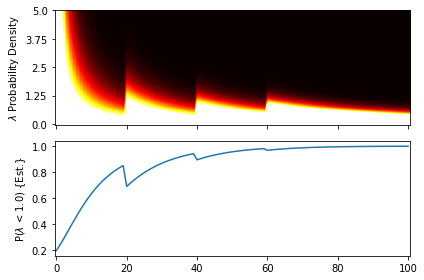

In [311]:
# show likelihood
rho_count = .3
lam_xvals = np.linspace(0,5,101)
likelihood = np.zeros((len(t),len(lam_xvals)))
d_lam = lam_xvals[1] - lam_xvals[0]
p_lower_likelihood = np.zeros(len(t))
for i,i_t in enumerate(t): 
    likelihood[:,i] = x_likelihood(lam_xvals,rho_count,K[i],i_t)
    p_lower_likelihood[i] = np.sum(likelihood[lam_xvals < mean_value,i]) / np.sum(np.sum(likelihood[:,i]))
    
fig2,ax2 = plt.subplots(ncols = 1,nrows = 2,sharex = True)
ax2[0].imshow(np.flipud(likelihood),cmap = 'hot',vmin = 0,vmax = .5,aspect="auto")
ax2[0].set_ylabel("$\lambda$ Probability Density")
ax2[0].set_yticks(np.arange(0,101,25))
ax2[0].set_yticklabels(np.flipud(lam_xvals[::25]))
ax2[1].plot(p_lower_likelihood)
ax2[1].set_ylabel("P($\lambda$ < 1.0) {Est.}")
fig2.tight_layout()

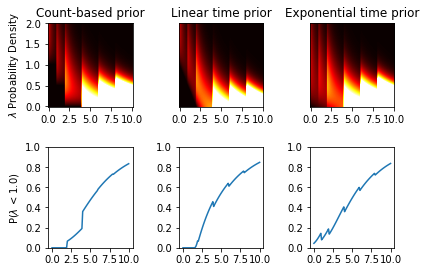

In [342]:
# Make a prior heatmap plot based on the prior component alone
rho_count = .5
rho_expo = .1
rho_linear = .5
lam_xvals = np.linspace(0,2,101)
t = np.linspace(0,10,101)
K = np.concatenate((np.full(10,0),np.full(10,1),np.full(20,2),np.full(20,3),np.full(20,4),np.full(21,5))) # functionalize this
posterior_count = np.zeros((len(t),len(lam_xvals)))
prior_linearTime = np.zeros((len(t),len(lam_xvals)))
prior_expoTime = np.zeros((len(t),len(lam_xvals)))
p_lower_count = np.zeros(len(t))
p_lower_linearTime = np.zeros(len(t))
p_lower_expoTime = np.zeros(len(t))
mean_value = .25

# First for a prior with count-based depletion
for i,i_t in enumerate(t): 
    i_likelihood = x_likelihood(lam_xvals,rho_count,K[i],i_t)
    prior_count[:,i] = i_likelihood * stats.gamma.pdf(lam_xvals + rho_count * K[i],2,1)
    prior_linearTime[:,i] = i_likelihood * stats.gamma.pdf(lam_xvals + rho_linear * i_t,2,1)
    prior_expoTime[:,i] = i_likelihood * stats.gamma.pdf(lam_xvals + np.exp(rho_expo * i_t),2,1)
    p_lower_count[i] = np.sum(prior_count[lam_xvals < mean_value,i]) / np.sum(np.sum(prior_count[:,i]))
    p_lower_linearTime[i] = np.sum(prior_linearTime[lam_xvals < mean_value,i]) / np.sum(np.sum(prior_linearTime[:,i]))
    p_lower_expoTime[i] = 1 - np.sum(prior_expoTime[lam_xvals > mean_value,i]) / np.sum(np.sum(prior_expoTime[:,i]))

# visualize
fig,ax = plt.subplots(ncols = 3,nrows = 2)
ax[0,0].imshow(np.flipud(prior_count),cmap = 'hot',vmin = 0,vmax = 1)
ax[0,0].set_title("Count-based prior")
ax[0,0].set_xticks(np.arange(0,101,25))
ax[0,0].set_xticklabels(t[::25])
ax[0,0].set_yticks(np.arange(0,101,25))
ax[0,0].set_yticklabels(np.flipud(lam_xvals[::25]))
ax[0,0].set_ylabel("$\lambda$ Probability Density")
ax[0,1].imshow(np.flipud(prior_linearTime),cmap = 'hot',vmin = 0,vmax = 1)
ax[0,1].set_title("Linear time prior")
ax[0,1].set_xticks(np.arange(0,101,25))
ax[0,1].set_xticklabels(t[::25]) 
ax[0,1].set_yticks([])
ax[0,2].imshow(np.flipud(prior_expoTime),cmap = 'hot',vmin = 0,vmax = 1)
ax[0,2].set_title("Exponential time prior")
ax[0,2].set_yticks([])
ax[0,2].set_xticks(np.arange(0,101,25))
ax[0,2].set_xticklabels(t[::25])
# plot probabilities
ax[1,0].plot(t,p_lower_count)
ax[1,0].set_ylim([0,1])
ax[1,0].set_ylabel("P($\lambda$ < 1.0)")
ax[1,0].set_xticks(t[::25])
ax[1,0].set_xticklabels(t[::25])
ax[1,1].plot(t,p_lower_linearTime)
ax[1,1].set_ylim([0,1])
ax[1,1].set_xticks(t[::25])
ax[1,2].plot(t,p_lower_expoTime)
ax[1,2].set_ylim([0,1])
ax[1,2].set_xticks(t[::25])
fig.tight_layout()


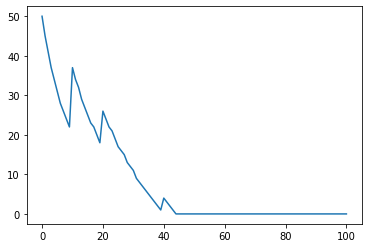

In [339]:
plt.plot(np.argmax(prior_expoTime,axis = 0))

## Changing the likelihood

This isn't really consistent with our behavior either; single reward events can have varying sizes. This is going to come down to changing the likelihood $p(x(t)|\lambda)$

Change to use Poisson?